In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import io
import time
import torch
import torchaudio

In [ ]:
from pathlib import Path
import json
from fastprogress import progress_bar, master_bar
import fastprogress
import numpy as np
import pylab as plt
import pandas as pd

# Distill Whisper with a RQ bottleneck (588hrs)

## Index the dataset

In [ ]:
# create an index of the data
fnames = []
all_samples = []
i = 0
mb = master_bar(list(Path(f'/mnt/whisper-distil/').glob('whisper-tiny-decoder-*')))
for dirname in mb:
    for name in progress_bar(list(dirname.rglob('*.whisper')), parent=mb):
        fnames.append(name)
        S = torch.load(name)
        all_samples += [(i,iS,iS*2250) for iS in range(S.shape[0]-1)]
        i += 1

In [ ]:
data = pd.DataFrame(dict(idx = all_samples))

In [ ]:
data['fname'] = data['idx'].map(lambda x: str(fnames[x[0]].relative_to('/mnt/whisper-distil/')))

In [ ]:
data.to_feather('whisper-tiny-emb-dataset.feather')

## Load the index and create Dataset objects

In [ ]:
data = pd.read_feather('whisper-tiny-emb-dataset.feather')

In [ ]:
len(data) * 30 / 3600

566.4333333333333

In [ ]:
import torch.nn.functional as F

class SADataset(torch.utils.data.Dataset):
    def __init__(self, data, basedir):
        self.data = data
        self.basedir = Path(basedir)
    
    def __len__(self):
        return len(self.data)
    
    def S_tokens(self):
        return len(self)*4500
    
    def hours(self):
        return len(self)*30/3600
    
    def __repr__(self):
        return f"Dataset: {len(self)} samples, {self.S_tokens()} Stokens, {self.hours():.1f} hours)"
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        i,iS,iA = row['idx']
        fname = row['fname']
        tokens = torch.load((self.basedir/fname).with_suffix('.tokens'))[iS]
        return torch.load(self.basedir/fname)[iS,0], F.pad(torch.tensor(tokens), (0, 200 - len(tokens)), value=tokenizer.encode('<|endoftext|>')[0])

In [ ]:
data[:124]

,idx,fname
0,"[0, 0, 0]",whisper-tiny-decoder-150/richard_cory_robinson...
1,"[0, 1, 2250]",whisper-tiny-decoder-150/richard_cory_robinson...
2,"[1, 0, 0]",whisper-tiny-decoder-150/canterburytales_16_ch...
3,"[1, 1, 2250]",whisper-tiny-decoder-150/canterburytales_16_ch...
4,"[1, 2, 4500]",whisper-tiny-decoder-150/canterburytales_16_ch...
...,...,...
119,"[7, 13, 29250]",whisper-tiny-decoder-1264/exterminationamerica...
120,"[7, 14, 31500]",whisper-tiny-decoder-1264/exterminationamerica...
121,"[7, 15, 33750]",whisper-tiny-decoder-1264/exterminationamerica...
122,"[7, 16, 36000]",whisper-tiny-decoder-1264/exterminationamerica...


In [ ]:
val_data, train_data = data[:124], data[124:]
val_ds = SADataset(val_data, '/mnt/whisper-distil/')
val_ds

Dataset: 124 samples, 558000 Stokens, 1.0 hours)

In [ ]:
train_ds = SADataset(train_data, '/mnt/whisper-distil/')
train_ds

Dataset: 67848 samples, 305316000 Stokens, 565.4 hours)

In [ ]:
train_ds[0][1]

tensor([50363,  2142,   362,    11,  7275,   352,    11,   286,   262, 48495,
          286,   262,  1605,   347,  1653,    13, 50627, 50627,   770,   318,
          257,  5261,    85,  1140,  8296,    13, 50721, 50721,   317,  5261,
           85,  1140, 18813,   389,   287,   262,  1171,  7386,    13, 50881,
        50881,  1114,   517,  1321,   393,   284, 13904,    11,  3387,  3187,
         5261,    85,  1140,    13,  2398,    13, 51169, 51169, 43905,   416,
         9308, 17099,   805,   379, 40440,  5189, 21607,    13,   785, 51401,
        51401,   383, 48495,   286,   262,  1605,   347,  1653,   416,  3977,
          309,    13, 13549, 43593,    13, 51625, 51625, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 

In [ ]:
import whisper
whmodel = whisper.load_model('tiny.en')
tokenizer = whisper.tokenizer.get_tokenizer(False, language='en')
whmodel.eval()

Whisper(
  (encoder): AudioEncoder(
    (conv1): Conv1d(80, 384, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(384, 384, kernel_size=(3,), stride=(2,), padding=(1,))
    (blocks): ModuleList(
      (0): ResidualAttentionBlock(
        (attn): MultiHeadAttention(
          (query): Linear(in_features=384, out_features=384, bias=True)
          (key): Linear(in_features=384, out_features=384, bias=False)
          (value): Linear(in_features=384, out_features=384, bias=True)
          (out): Linear(in_features=384, out_features=384, bias=True)
        )
        (attn_ln): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=384, out_features=1536, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=1536, out_features=384, bias=True)
        )
        (mlp_ln): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      )
      (1): ResidualAttentionBlock(
        (attn): Mult

In [ ]:
class VQVisual:
    def __init__ (self, model, total_steps):
        self.model = model
        self.total_steps = total_steps
        self.q_depth = len(model.rq.layers)
        
        gs = plt.GridSpec(3, 1, height_ratios=[2, 1, 1])
        vq_gs = gs[1].subgridspec(1, self.q_depth)
        codebook_gs = gs[2].subgridspec(1, self.q_depth)
        graph_fig = plt.figure(figsize=(10,6))
        self.graph_fig = graph_fig
        self.loss_p = graph_fig.add_subplot(gs[0])
        self.vq_p = [graph_fig.add_subplot(vq_gs[i]) for i in range(self.q_depth)]
        self.codebook_p = [graph_fig.add_subplot(codebook_gs[i]) for i in range(self.q_depth)]
        self.graph_out = None
        
        self.its = []
        self.train_losses = []
        self.val_losses = []
        self.lr_history = []
        
        self.vq_usage_history = []
        self.vq_range_history = []
        
        self.max_vq_usage = torch.tensor([5.]*self.q_depth)
        self.vq_range = torch.tensor([-2.,2.,-2.,2.]).repeat(self.q_depth,1)
    
    def show(self):
        self.graph_out = display(self.graph_fig, display_id=True, clear=True)
    
    def hide(self):
        if self.graph_out is not None:
            self.graph_out.update(IPython.display.HTML(''))
    
    def plot(self):
        loss_p, vq_p, codebook_p = self.loss_p, self.vq_p, self.codebook_p
        loss_p.clear()
        loss_p.plot(self.its, self.train_losses)
        loss_p.plot(self.its, self.val_losses)
        loss_p.set_xlim(0, self.total_steps)
        loss_p.set_yscale('log')
        vq_range = torch.tensor([-2,2,-2,2]).repeat(self.q_depth,1)
        for i in range(self.q_depth):
            vq = self.model.rq.layers[i]
            cls = vq._codebook.cluster_size
            vq_p[i].clear()
            vq_p[i].fill_between(range(cls.shape[1]), 0, torch.sort(cls, descending=True).values.cpu().numpy()[0])
            vq_p[i].margins(0,0)
            vq_p[i].spines['top'].set_visible(False)
            vq_p[i].spines['right'].set_visible(False)
            vq_p[i].spines['bottom'].set_visible(False)
            vq_p[i].spines['left'].set_visible(False)
            vq_p[i].set_ylim(0, self.max_vq_usage[i])
            used_codes = (cls > 0.1).sum()
            vq_p[i].text(0.5, 0.9, f'{int(used_codes)}', horizontalalignment='center',
                 verticalalignment='center', transform=vq_p[i].transAxes)
            self.max_vq_usage[i] = cls.max().item()
            cd = vq._codebook.embed
            codebook_p[i].clear()
            codebook_p[i].scatter(vq.codebook[:,0].cpu(), vq.codebook[:,1].cpu(), s=vq._codebook.cluster_size.cpu(), alpha=.2)
            s = self.vq_range[i]
            margin = (s[1::2] - s[0::2])*0.1
            s[0::2] -= margin
            s[1::2] += margin
            codebook_p[i].set_xlim(*s[0:2])
            codebook_p[i].set_ylim(*s[2:4])
            self.vq_range[i] = torch.tensor([vq.codebook[:,0].min(), vq.codebook[:,0].max(), vq.codebook[:,1].min(), vq.codebook[:,1].max()])
        self.vq_range_history.append(self.vq_range)
        s = self.vq_range_history[-10:]
        self.vq_range = sum(s) / len(s)
        self.vq_usage_history.append(self.max_vq_usage)
        s = self.vq_usage_history[-10:]
        self.max_vq_usage = sum(s) / len(s)
        self.graph_out.update(self.graph_fig)
    
    def add_data(self, it, lr, train_loss, val_los):
        self.its.append(it)
        self.train_losses.append(train_loss)
        self.val_losses.append(val_los)
        self.lr_history.append(lr)
        self.plot()

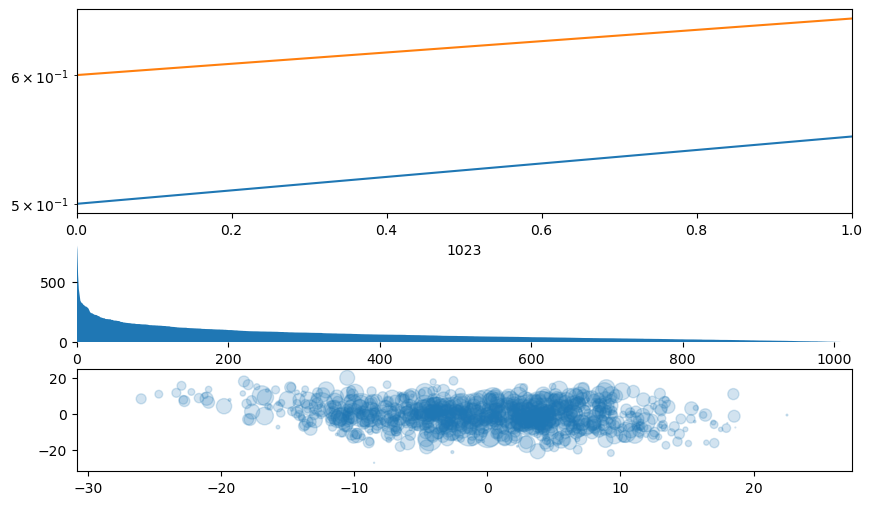

In [ ]:
# test VQVisual
visual = VQVisual(vqmodel, 1)
visual.show()
visual.add_data(0, 1e-4, 0.5, 0.6)
visual.add_data(1, 1.2e-4, 0.55, 0.65)
visual.hide()

In [ ]:
# training code
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
import random
import IPython

def train(model_name, model, train, val, half=False, bs=16, lr=1e-4, visual_class = VQVisual,
          weight_decay=0.1, pct_start=0.3, warmup=5000, warmup_mul=1e-2, epochs=10,
          run_valid_every_iters=100, table_row_every_iters=1000,
          device="cuda"):
    try:
        scheduler = None
        visual = visual_class(model, epochs*len(train))
        all_params = set(model.parameters())
        wd_params = set()
        for m in model.modules():
            if isinstance(m, (nn.Linear, nn.Conv1d)):
                wd_params.add(m.weight)
                if m.bias is not None:
                    wd_params.add(m.bias)
        no_wd_params = all_params - wd_params

        optimizer = torch.optim.AdamW(lr=lr * warmup_mul, betas=(0.9, 0.95), #fused=True,
            params=[
                {"params": list(wd_params), "weight_decay": weight_decay},
                {"params": list(no_wd_params), "weight_decay": 0.0},
            ]
        )
        scaler = torch.cuda.amp.GradScaler(enabled=half)

        train_loader = DataLoader(train, batch_size=bs, num_workers=0, drop_last=False, shuffle=True)
        val_loader = DataLoader(val, batch_size=bs, num_workers=0, drop_last=False)
        chkpt_every_iters = 5000

        it = 0
        start_t = time.time()
        next_val_it = it + 50
        next_chkpt_it = chkpt_every_iters
        next_table_it = table_row_every_iters
        
        commit_loss = torch.nan
        ce_loss = torch.nan
        kl_loss = torch.nan
        val_loss = torch.nan
        avg_train_loss = torch.nan
        
        visual.show()

        mb = master_bar(range(epochs))
        mb.write(["samples", "train", "val", "time"], table=True)
        running_loss = [0]
        for epoch in mb:
            bar = progress_bar(train_loader, parent=mb)
            for xs,ys in bar:
                # zero the parameter gradients
                optimizer.zero_grad(set_to_none=True)

                with torch.autocast(device_type=device, dtype=torch.float16 if half else torch.float32, enabled=device!='cpu'):
                    ps, loss = model(xs.float().to(device), ys.to(device))

                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

                if it > warmup:
                    if scheduler is None:
                        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, pct_start=pct_start, steps_per_epoch=len(train_loader), epochs=epochs)
                    else:
                        scheduler.step()
                        lr = scheduler.get_last_lr()                    

                running_loss.append(loss.item())
                running_loss = running_loss[-5:]
                avg_train_loss = sum(running_loss)/len(running_loss)

                if it >= next_chkpt_it:
                    next_chkpt_it += chkpt_every_iters
                    torch.save(vqmodel.state_dict(), f'{model_name}-{it}.pt')
                    
                if it >= next_val_it:
                    next_val_it += run_valid_every_iters
                    model.eval()
                    with torch.no_grad():
                        val_loss = 0
                        commit_loss = 0
                        ce_loss = 0
                        kl_loss = 0
                        for xs,ys in val_loader:
                            with torch.autocast(device_type=device, dtype=torch.float16 if half else torch.float32, enabled=device!='cpu'):
                                ps, loss = model(xs.to(device), ys.to(device))
                            val_loss += loss
                            commit_loss += model.commit_loss
                            ce_loss += model.ce_loss
                            kl_loss += model.kl_loss
                        N = len(val_loader)
                        val_loss = val_loss.item() / N; commit_loss = commit_loss.item() / N; ce_loss = ce_loss.item() / N; kl_loss = kl_loss.item() / N;
                    model.train()
                    visual.add_data(it, lr, avg_train_loss, val_loss)
                
                if it >= next_table_it:
                    elapsed_t = time.time() - start_t
                    next_table_it += table_row_every_iters
                    mb.write([it, f"{avg_train_loss:.5f}", f"{val_loss:.5f}", fastprogress.core.format_time(elapsed_t)], table=True)

                it += bs
                bar.comment = f"#{epoch+1}/{epochs} loss: {avg_train_loss:.3f} / {val_loss:.3f} commit: {commit_loss:.3f} ce: {ce_loss:.3f} kl: {kl_loss:.3f}"
    except KeyboardInterrupt:
        mb.write(f"interrupted")
        mb.show()
        pass
    finally:
        visual.hide()

In [ ]:
def glue_tensors(x, prefix=None, suffix=None, dim=-2):
    expand = [x.shape[0]] + [1 for _ in x.shape[1:]]
    l = []
    if prefix:
        l.append(torch.tensor(prefix).to(x.device).expand(expand))
    l.append(x)
    if suffix:
        l.append(torch.tensor(suffix).to(x.device).expand(expand))
    return torch.cat(l, dim=dim)

In [ ]:
# the model
import whisper
from torch import nn
from vector_quantize_pytorch import ResidualVQ

class LayerNorm(nn.LayerNorm):
    def forward(self, x):
        return super().forward(x.float()).type(x.dtype)
    
def sinusoids(length, channels, max_timescale=10000):
    """Returns sinusoids for positional embedding"""
    assert channels % 2 == 0
    log_timescale_increment = np.log(max_timescale) / (channels // 2 - 1)
    inv_timescales = torch.exp(-log_timescale_increment * torch.arange(channels // 2))
    scaled_time = torch.arange(length)[:, np.newaxis] * inv_timescales[np.newaxis, :]
    return torch.cat([torch.sin(scaled_time), torch.cos(scaled_time)], dim=1)
    
class RQBottleneckTransformer(nn.Module):
    def __init__(self, width=384, vq_codes=512, q_depth=12, depth=1, n_head=2,
                 codebook_dim=2, threshold_ema_dead_code=2, use_cosine_sim = False, kl_loss_mul=1):
        super(RQBottleneckTransformer, self).__init__()
        self.vq_codes = vq_codes
        self.kl_loss_mul = kl_loss_mul
        
        self.in_blocks = nn.Sequential(*[
            whisper.model.ResidualAttentionBlock(width, n_head) for _ in range(depth)
        ])
        self.ln_vq = LayerNorm(width)

        self.rq = ResidualVQ(
            dim = width,
            codebook_size = vq_codes, # codebook size
            decay = 0.8,              # the exponential moving average decay, lower means the dictionary will change faster
            commitment_weight = 1.,   # the weight on the commitment loss
            threshold_ema_dead_code = threshold_ema_dead_code,
            use_cosine_sim = use_cosine_sim,
            codebook_dim = codebook_dim,
            num_quantizers= q_depth,
        )
        
        self.ce_lossf = nn.CrossEntropyLoss(ignore_index=tokenizer.encode('<|endoftext|>')[0])
        self.kl_lossf = nn.KLDivLoss(reduction='batchmean')

        self.register_buffer("positional_embedding", sinusoids(1500, width))
        
        self.out_blocks = nn.Sequential(*[
            whisper.model.ResidualAttentionBlock(width, n_head) for _ in range(depth)
        ])
        self.ln_post = LayerNorm(width)

    def encode(self, xin):
        x = self.ln_vq(self.in_blocks(xin))
        _, indices, _ = self.rq(x)
        return indices
        
    def forward(self, xin, tokens=False):
        x = self.ln_vq(self.in_blocks(xin))
        quantized, self.indices, self.commit_loss = self.rq(x)
        self.commit_loss = self.commit_loss.mean()
        x = self.ln_post(self.out_blocks((quantized + self.positional_embedding).to(xin.dtype)))
        self.err = torch.tensor(torch.nan)
        if tokens is not False:
            ts = glue_tensors(tokens[:,:-1], prefix=tokenizer.sot, dim=-1)
#             print(tokens.shape, ts.shape, xin.shape)
            with torch.no_grad():
                teacher_logits = whmodel.decoder(ts, xin)
            logits = whmodel.decoder(ts, x)
            self.ce_loss = self.ce_lossf(logits.view(-1,logits.shape[-1]), tokens.view(-1))
            self.kl_loss = self.kl_lossf(F.log_softmax(logits, dim=-1), F.softmax(teacher_logits, dim=-1))
            loss = self.ce_loss + self.kl_loss_mul * self.kl_loss + self.commit_loss
            return x, loss
        else:
            return x

samples,train,val,time
20000,453.37674,430.14838,23:40
40000,436.71777,422.17944,35:55
60000,428.53935,415.45056,48:40
80000,429.03522,407.54550,1:00:49
100000,347.16329,316.04224,1:12:43
120000,229.24652,157.26317,1:24:44
140000,179.13503,126.35532,1:36:39
160000,133.32237,89.70000,1:49:09
180000,116.15156,79.47621,2:01:20
200000,103.99197,64.76176,2:13:29


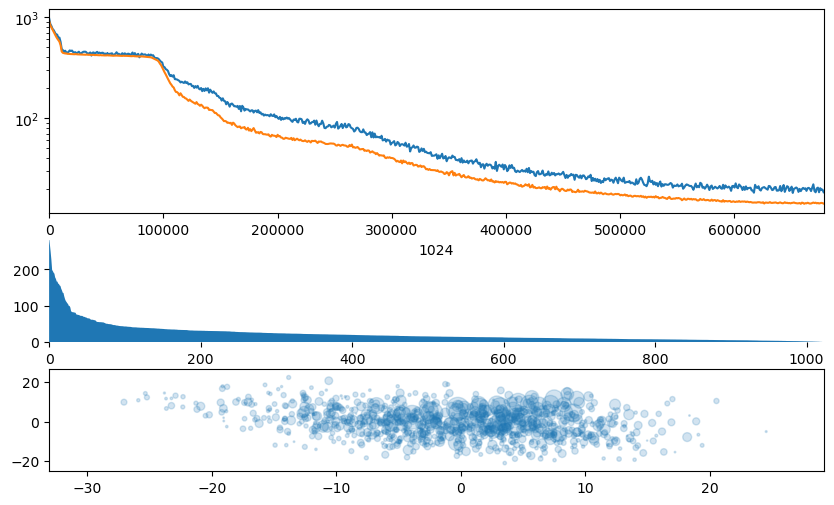

In [ ]:
# with positional embeddings, 10 bit bottleneck (1 quantizer, 1024 codes)
vqmodel = RQBottleneckTransformer(codebook_dim=16, vq_codes=1024, q_depth=1, n_head=6, depth=1,
                                  threshold_ema_dead_code=0.1).cuda()
train("svq", vqmodel, train_ds, val_ds, epochs=10, lr=8e-4, warmup_mul=1e-3, warmup=10000,
      run_valid_every_iters=1000, table_row_every_iters=20000)

In [ ]:
torch.save(vqmodel.state_dict(), 'vqmodel2-tiny-600h.pth')

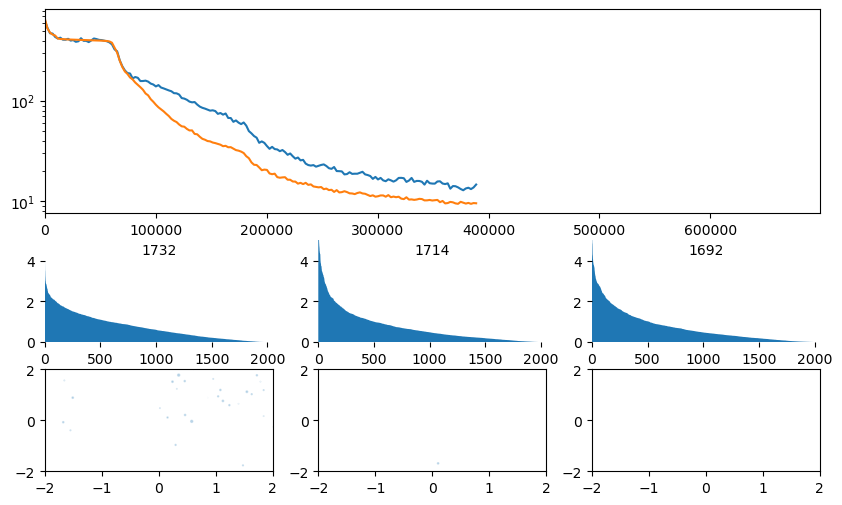

train,val
255.175,252.888
92.039,46.431
33.051,18.754
18.741,11.717
14.933,10.113


KeyboardInterrupt: 

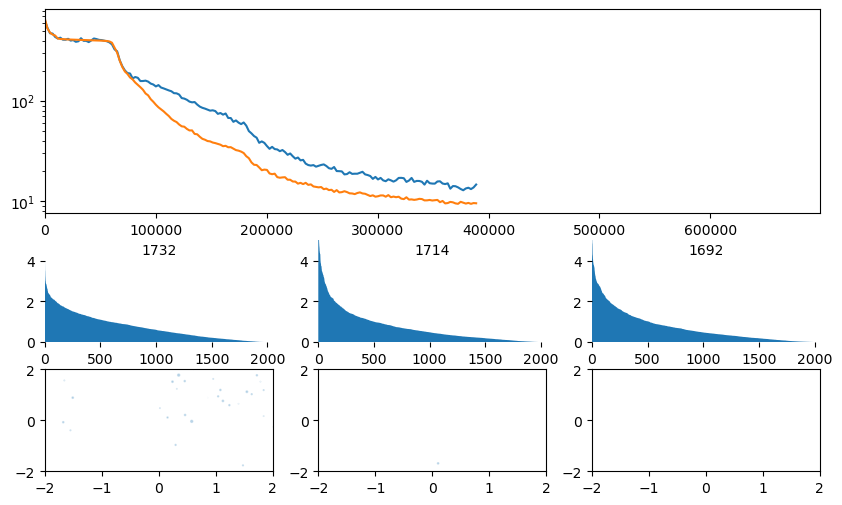

In [ ]:
# without adding positional embeddings after VQ, 33 bit bottleneck (3 quantizers, 2048 codes)
vqmodel = RQBottleneckTransformer(codebook_dim=16, vq_codes=2048, q_depth=3, n_head=6, depth=1,
                                  threshold_ema_dead_code=0.1).cuda()
train(vqmodel, frames, tokens, epochs=10, lr=1e-4, warmup_mul=1e-3, warmup=10000)

## Check the decoder performance with and without the RQ bottleneck

In [ ]:
tokenizer.decode(whmodel.decoder(torch.tensor(list(tokenizer.sot_sequence) + tokens[0]).repeat(1,1).cuda(), frames[0][0].cuda()).argmax(-1)[0])

' Richard Corrie by Edwin Arlington Robinson, read for librovox.org by Fox and the stars of shininghalf.com. Whenever Richard Corrie went downtown, we people on the pavement looked at him. He He was a gentleman from Seoul to crown, clean favored, and impurially slim.<|endoftext|>'

In [ ]:
# probably a bit better with more data, good enough for now
tokenizer.decode(whmodel.decoder(torch.tensor(list(tokenizer.sot_sequence) + tokens[0]).repeat(1,1).cuda(), vqmodel(frames[0][0].cuda().to(torch.float32))).argmax(-1)[0])

'<|nospeech|> Richard Coryrie by Edwin Arlington Robinson, read for Libroox.org by Fox in the Stars of shining half.com. Whenever Richard Corrie went downtown, we people on the pavement looked at him. He He was a gentleman from sold to Crown, clean favored and and impurially slim.<|endoftext|>'

# Semantic token extraction
## Load the trained model

In [ ]:
vqmodel = RQBottleneckTransformer(codebook_dim=16, vq_codes=1024, q_depth=1, n_head=6, depth=1,
                                  threshold_ema_dead_code=0.1)
vqmodel.load_state_dict(torch.load('./vqmodel2-tiny-600h.pth'))
vqmodel.eval().cuda()

RQBottleneckTransformer(
  (in_blocks): Sequential(
    (0): ResidualAttentionBlock(
      (attn): MultiHeadAttention(
        (query): Linear(in_features=384, out_features=384, bias=True)
        (key): Linear(in_features=384, out_features=384, bias=False)
        (value): Linear(in_features=384, out_features=384, bias=True)
        (out): Linear(in_features=384, out_features=384, bias=True)
      )
      (attn_ln): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=384, out_features=1536, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=1536, out_features=384, bias=True)
      )
      (mlp_ln): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
    )
  )
  (ln_vq): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
  (rq): ResidualVQ(
    (layers): ModuleList(
      (0): VectorQuantize(
        (project_in): Linear(in_features=384, out_features=16, bias=True)
        (project_out): Linea

### Generate and save all semantic tokens (stoks)

In [ ]:
mb = master_bar(list(Path(f'/mnt/semantic-medium/').glob('*')))
for dirname in mb:
    for name in progress_bar(list(dirname.rglob('*.semb')), parent=mb):
        semtoks = vqmodel.encode(torch.load(name).cuda().to(torch.float32).squeeze(1))
        torch.save(semtoks.to(torch.int16).cpu(), name.with_suffix('.stoks'))

In [ ]:
mb = master_bar(list(Path(f'/mnt/semantic-small/').glob('*')))
for dirname in mb:
    for name in progress_bar(list(dirname.rglob('*.semb')), parent=mb):
        semtoks = vqmodel.encode(torch.load(name).cuda().to(torch.float32).squeeze(1))
        torch.save(semtoks.to(torch.int16).cpu(), name.with_suffix('.stoks'))

### Load and verify a single sample (the sample indices came from "3. Semantic to acoustic token modeling")

In [ ]:
fname = Path('/mnt/semantic-small/1401/marylouiseinthecountry_20_baum_64kb.stoks')
emb_fname = Path('/mnt/semantic-small/1401/marylouiseinthecountry_20_baum_64kb.semb')

In [ ]:
import whisper
whmodel = whisper.load_model('tiny.en')

In [ ]:
(vqmodel.encode(torch.load(emb_fname)[8].cuda()) == torch.load(fname)[8].cuda()).all()

tensor(False, device='cuda:0')

In [ ]:
whmodel.decode(torch.load(emb_fname)[8].cuda(), whisper.DecodingOptions(language='en'))[0].text

'to little at her sarcasm but soon collected himself. Strangely enough he did not appear to be angry with her. I have neglected you, he repeated, but it has been an oversight. I have so much on my mind that I scarcely realized you were here. I forgot you are a nans child and that you, you needed attention. Inglop had on her new hat, looking into a cracked mirror. You might remember it on a crag anyhow, she said, mollified by his tone of self-approach,'

In [ ]:
whmodel.decode(vqmodel(torch.load(emb_fname)[8].cuda()), whisper.DecodingOptions(language='en'))[0].text

"to little at her sarcasm but soon collected himself. Strangely enough he did not appear to be angry with her. I've neglected you, he repeated, but it has been an oversight. I have so much on my mind that I scarcely realized you were here. I forgot you are Nan's child and that you, you needed attention. Inglut on her new hat, looking into a cracked mirror. You might remember I'm a Craig anyhow, she said, mollified by his tone of self-approach,"

In [ ]:
Atoks = torch.load(Path('/mnt/acoustic-1401')/fname.with_suffix('.encodec').name)[0]
Atoks

tensor([[ 62,  62,  62,  ...,  62,  62,  62],
        [913, 424, 424,  ..., 518, 518, 518]], device='cuda:0')

In [ ]:
from spear_tts_pytorch.extract_acoustic import load_model

In [ ]:
Amodel = load_model()

In [ ]:
with torch.no_grad():
    audio = Amodel.decode([(Atoks[:,18000:18000+2250].unsqueeze(0),None)])

In [ ]:
audio.shape

torch.Size([1, 1, 720000])

In [ ]:
torchaudio.save('test.wav', audio[0].cpu(), sample_rate=24000)

In [ ]:
%%html
<a href="./test.wav" target="_blank">Listen to the sample</a>